#**PROBLEMA DE NEGOCIO**


---




##Una entidad gubernamental responsable de la gestión de la salud en un país enfrenta el desafío de comprender y analizar la propagación del COVID-19 para tomar decisiones informadas y eficaces en la gestión de la pandemia.

In [ ]:
# Verificacion de versiones de python y librerias
#!python -V
#print('------')
#!pip show Pandas | grep 'Name\|Version'
#print('------')
#!pip show Matplotlib | grep 'Name\|Version'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mp
import sklearn as sl
import requests
import seaborn as sns
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.text import Text
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
global df_covid, df_population, df_covid_limpio, df_population_limpio

In [ ]:
df_covid = pd.read_csv(StringIO(requests.get("https://covid19.who.int/WHO-COVID-19-global-data.csv").text))
df_population = pd.read_excel('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx', sheet_name=0, skiprows=16)
df_population = df_population[df_population['Year'] == 2019]

## Data 1 - WHO Covid-19-Global

In [ ]:
# Informacion de datos antes de la limpieza
print('Información:')
print(df_covid.info())
print('------------')
print('Duplicados:')
print(df_covid.duplicated().sum())
print('------------')
print('Registros nulos')
print(df_covid.isnull().sum())
print('------------')

Información:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50880 entries, 0 to 50879
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      50880 non-null  object 
 1   Country_code       49396 non-null  object 
 2   Country            49608 non-null  object 
 3   WHO_region         45792 non-null  object 
 4   New_cases          36622 non-null  float64
 5   Cumulative_cases   50880 non-null  int64  
 6   New_deaths         24216 non-null  float64
 7   Cumulative_deaths  50880 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB
None
------------
Duplicados:
211
------------
Registros nulos
Date_reported            0
Country_code          1484
Country               1272
WHO_region            5088
New_cases            14258
Cumulative_cases         0
New_deaths           26664
Cumulative_deaths        0
dtype: int64
------------


In [ ]:
# funcion para limpiar los datos requeridos de un dataframe:
def limpieza_de_datos():
  df = df_covid.copy()
  df = asignar_country_code_namibia(df)
  df = eliminar_country_code_nulos(df)
  df = filtrar_columnas(df)
  df = nulos_x_cero(df)
  df = cambiar_datetime(df)
  df = convertir_columnas(df)
  df = crear_lethality_rate(df)
  df = nulos_lethality_x_ceros(df)
  df = calcular_cuantiles(df)
  df = renombrar_paises_largos(df)
  df.columns.name = 'Id'
  df = actualizar_indice(df)
  return df

In [ ]:
# funciones para realizar las operaciones de limpieza a un dataframe
def asignar_country_code_namibia(df):
  df.loc[df['Country'] == 'Namibia', 'Country_code'] = 'NA'
  return df

def eliminar_country_code_nulos(df):
  # opcion2: guardar el resultado en la misma variable
  # df.dropna(subset=['Country_code'], inplace=True)
  return df.dropna(subset=['Country_code'])

def filtrar_columnas(df):
  return df.filter(['Date_reported', 'Country_code', 'Country', 'New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths'])

def nulos_x_cero(df):
  return df.fillna({'Date_reported': 0,
                                    'Country_code' : 0,
                                    'Country': 0,
                                    'New_cases': 0,
                                    'Comulative_cases': 0,
                                    'New_deaths': 0,
                                    'Comulative_deaths':0
                                    })

def cambiar_datetime(df):
  df['Date_reported'] = pd.to_datetime(df['Date_reported'], format = '%Y-%m-%d')
  return df

def convertir_columnas(df):
  df['New_cases'] = df['New_cases'].astype('int64')
  df['New_deaths'] = df['New_deaths'].astype('int64')
  return df

def crear_lethality_rate(df):
  df['lethality_rate'] = (df['Cumulative_deaths'] / df['Cumulative_cases']) * 100
  return df

def nulos_lethality_x_ceros(df):
  df['lethality_rate'].fillna(0, inplace=True)
  return df

def calcular_cuantiles(df):
  lower_quantile = df['lethality_rate'].quantile(0.00)
  upper_quantile = df['lethality_rate'].quantile(0.99)
  df = df[(df['lethality_rate'] >= lower_quantile) & (df['lethality_rate'] <= upper_quantile)]
  return df

def renombrar_paises_largos(df):
  df['Country'] = df['Country'].replace("United Kingdom of Great Britain and Northern Ireland", "United Kingdom")
  df['Country'] = df['Country'].replace("United States of America", "USA")
  return df

def actualizar_indice(df):
  return df.reset_index(drop = True)

In [ ]:
df_covid[df_covid['Country_code'].isnull()]

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
8692,2020-01-05,NaN,NaN,NaN,NaN,0,NaN,0
8693,2020-01-12,NaN,NaN,NaN,NaN,0,NaN,0
8694,2020-01-19,NaN,NaN,NaN,NaN,0,NaN,0
8695,2020-01-26,NaN,NaN,NaN,NaN,0,NaN,0
8696,2020-02-02,NaN,NaN,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...
31795,2023-12-24,NaN,Namibia,AFRO,NaN,172239,NaN,4103
31796,2023-12-31,NaN,Namibia,AFRO,10.0,172249,NaN,4103
31797,2024-01-07,NaN,Namibia,AFRO,3.0,172252,NaN,4103
31798,2024-01-14,NaN,Namibia,AFRO,4.0,172256,NaN,4103


In [ ]:
df_covid_limpio = limpieza_de_datos()

In [ ]:
df_covid_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49111 entries, 0 to 49110
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      49111 non-null  datetime64[ns]
 1   Country_code       49111 non-null  object        
 2   Country            49111 non-null  object        
 3   New_cases          49111 non-null  int64         
 4   Cumulative_cases   49111 non-null  int64         
 5   New_deaths         49111 non-null  int64         
 6   Cumulative_deaths  49111 non-null  int64         
 7   lethality_rate     49111 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


In [ ]:
df_covid_limpio

Id,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
0,2020-01-05,AF,Afghanistan,0,0,0,0,0.000000
1,2020-01-12,AF,Afghanistan,0,0,0,0,0.000000
2,2020-01-19,AF,Afghanistan,0,0,0,0,0.000000
3,2020-01-26,AF,Afghanistan,0,0,0,0,0.000000
4,2020-02-02,AF,Afghanistan,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...
49106,2023-12-24,ZW,Zimbabwe,23,266048,1,5731,2.154123
49107,2023-12-31,ZW,Zimbabwe,23,266071,0,5731,2.153936
49108,2024-01-07,ZW,Zimbabwe,46,266117,3,5734,2.154691
49109,2024-01-14,ZW,Zimbabwe,85,266202,3,5737,2.155130


In [ ]:
# guardado del dataframe limpio en un nuevo .csv, descomentar las 3 lineas siguientes:
#from google.colab import files
#df_covid_limpio.to_csv("df_covid_limpio.csv")
#files.download("df_covid_limpio.csv")

## Data 2 - Population Demographic Indicators

In [ ]:
# Informacion de datos antes de la limpieza
print('===============================================')
print(' Informacion de datos antes de la limpieza:    ')
print('===============================================')
print('Información:')
print(df_population.info())
print('------------')
print('Duplicados:')
print(df_population.duplicated().sum())
print('------------')
print('Registros nulos')
print(df_population.isnull().sum())
print('------------')

 Informacion de datos antes de la limpieza:    
Información:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 69 to 20593
Data columns (total 65 columns):
 #   Column                                                                                          Non-Null Count  Dtype  
---  ------                                                                                          --------------  -----  
 0   Index                                                                                           286 non-null    int64  
 1   Variant                                                                                         286 non-null    object 
 2   Region, subregion, country or area *                                                            286 non-null    object 
 3   Notes                                                                                           76 non-null     object 
 4   Location code                                                               

In [ ]:
# funcion para limpiar los datos requeridos de un dataframe:
def limpieza_de_datos2():
  df = df_population.copy()
  df = eliminar_columnas_innecesarias(df)
  df = renombrar_columnas(df)
  df = convertir_columnas2(df)
  df = multiplicar_columnas_x_100(df)
  df = eliminar_country_code_nulos(df)
  df.columns.name = 'Id'
  df = actualizar_indice(df)
  return df

In [ ]:
# funciones para realizar las operaciones de limpieza a un dataframe
def eliminar_columnas_innecesarias(df):
  columnas_a_mantener = ['ISO2 Alpha-code','Total Population, as of 1 July (thousands)','Male Population, as of 1 July (thousands)','Female Population, as of 1 July (thousands)','Population Density, as of 1 July (persons per square km)','Life Expectancy at Birth, both sexes (years)']
  df = df[columnas_a_mantener]
  return df

# Renombrar ciertas columnas para una mejor lectura
def renombrar_columnas(df):
  df.rename(columns={'ISO2 Alpha-code': 'Country_code', 'Total Population, as of 1 July (thousands)': 'Total_Population',
    'Male Population, as of 1 July (thousands)': 'Male_Population',
    'Female Population, as of 1 July (thousands)': 'Female_Population',
    'Population Density, as of 1 July (persons per square km)': 'Population_Density',
    'Life Expectancy at Birth, both sexes (years)': 'Life_Expectancy'},
               inplace=True)
  return df

#sustituir el fomato de las columnas requeridas a int64
def convertir_columnas2(df):
  columnas = ['Total_Population', 'Male_Population', 'Female_Population', 'Population_Density', 'Life_Expectancy']
  for col in columnas:
    df[col] = pd.to_numeric(df[col], errors='coerce')
  df = df.dropna()
  df[columnas] = df[columnas].astype('int64')
  return df

# Multiplicar x 1000 3 columnas requeridas
def multiplicar_columnas_x_100(df):
  df['Total_Population'] = df['Total_Population'] * 1000
  df['Male_Population'] = df['Male_Population'] * 1000
  df['Female_Population'] = df['Female_Population'] * 1000
  return df

In [ ]:
df_population_limpio = limpieza_de_datos2()

<ipython-input-15-c5a7c77bf584>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columnas] = df[columnas].astype('int64')


In [ ]:
# Informacion de datos despues de la limpieza
print('===============================================')
print(' Informacion de datos despues de la limpieza:  ')
print('===============================================')
print('Información:')
print(df_population_limpio.info())
print('------------')
print('Duplicados:')
print(df_population_limpio.duplicated().sum())
print('------------')
print('Registros nulos:')
print(df_population_limpio.isnull().sum())
print('------------')

 Informacion de datos despues de la limpieza:  
Información:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country_code        235 non-null    object
 1   Total_Population    235 non-null    int64 
 2   Male_Population     235 non-null    int64 
 3   Female_Population   235 non-null    int64 
 4   Population_Density  235 non-null    int64 
 5   Life_Expectancy     235 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 11.1+ KB
None
------------
Duplicados:
0
------------
Registros nulos:
Id
Country_code          0
Total_Population      0
Male_Population       0
Female_Population     0
Population_Density    0
Life_Expectancy       0
dtype: int64
------------


In [ ]:
df_population_limpio

Id,Country_code,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy
0,BI,11874000,5894000,5980000,457,62
1,KM,790000,397000,393000,425,64
2,DJ,1073000,533000,540000,46,63
3,ER,3498000,1724000,1773000,28,67
4,ET,114120000,57375000,56745000,114,65
...,...,...,...,...,...,...
230,WS,211000,108000,103000,74,72
231,TK,1000,0,0,146,75
232,TO,104000,51000,52000,161,70
233,TV,10000,5000,5000,365,64


In [ ]:
# Descomentar las siguientes lineas para descargar el Data limpio
#from google.colab import files
#df_population_limpio.to_csv("df_population_limpio.csv")
#files.download("df_population_limpio.csv")

In [ ]:
df_colombia = df_covid_limpio[df_covid_limpio['Country'] == 'Colombia']
df_colombia.head()

Id,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
9063,2020-01-05,CO,Colombia,0,0,0,0,0.0
9064,2020-01-12,CO,Colombia,0,0,0,0,0.0
9065,2020-01-19,CO,Colombia,0,0,0,0,0.0
9066,2020-01-26,CO,Colombia,0,0,0,0,0.0
9067,2020-02-02,CO,Colombia,0,0,0,0,0.0


## Cuál es la Población de Colombia en comparación co los países con más casos Covi-19

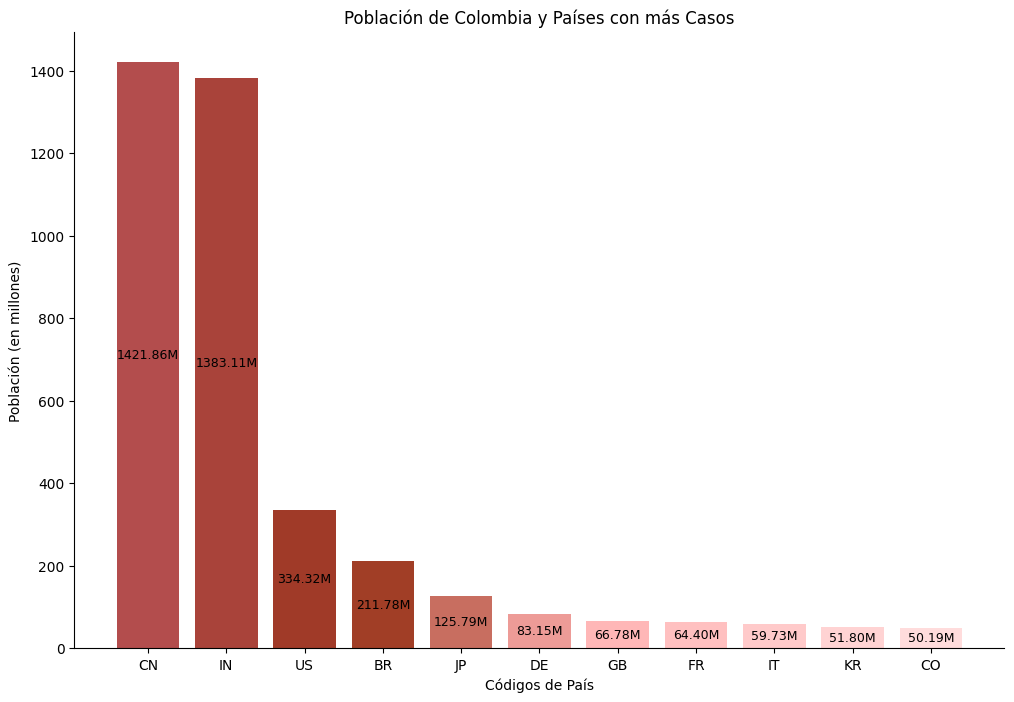

In [ ]:
# Agrupar por pais y elegir el maximo de Population
total_por_pais_population = df_population_limpio.groupby('Country_code')['Total_Population'].max()

country_codes = ['CN', 'IN', 'US', 'BR', 'JP', 'DE', 'GB', 'FR', 'IT', 'KR', 'CO']

# Crear una lista vacía para almacenar las series
lista_series = []

# Suponiendo que 'total_por_pais_population' es tu DataFrame original
# y 'Population' es la columna que deseas utilizar

# Ciclo for para crear y agregar las series a la lista
for code in country_codes:
    series_pais = total_por_pais_population.loc[code]
    lista_series.append(pd.Series(series_pais, index=[code]))

# Crear un gráfico de barras para Población
fig, ax = plt.subplots(figsize=(12, 8))

colors = [(0.7, 0.3, 0.3), (0.6, 0.2, 0.1), (1.0, 0.7, 0.7), (1.0, 0.8, 0.8), (1.0, 0.9, 0.9)]
cmap = LinearSegmentedColormap.from_list('Custom Reds', colors)

# Plotear las barras con colores rojos suaves y grosor aumentado
bar_width = 0.8
bar_positions = np.arange(len(country_codes))

for i, code in enumerate(country_codes):
    value_in_millions = total_por_pais_population[code] / 1_000_000
    color = cmap(i / len(country_codes))
    ax.bar(i, value_in_millions, width=bar_width, color=color)

    # Añadir etiqueta con el valor en millones en medio de la barra
    ax.text(i, value_in_millions / 2, f'{value_in_millions:.2f}M', fontsize=9, ha='center', va='center', color='black')

# Añadir etiquetas y título
ax.set_xlabel('Códigos de País')
ax.set_ylabel('Población (en millones)')
ax.set_title('Población de Colombia y Países con más Casos')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)

# Configurar los ticks del eje x
plt.xticks(bar_positions, country_codes)

# Mostrar el gráfico
plt.show()

Conclusión:
Colombia tiene una poblacion de 50.19 millones, está muy parejo con respecto a los últimos 4 del top 10 más importantes a nivel global, Conclusión: Colombia tiene una poblacion de 50.19 millones, está muy parejo con respecto a los últimos 4 del top 10 más importantes a nivel global, pero China e India son los países con mayor población mundial.

## 1. ¿Cómo ha evolucionado el Covid-19 en Colombia en comparación con el impacto observado a nivel global?

In [ ]:
## Pais elegido Colombia

# Agrupar por pais y elegir el maximo
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max()

# Ordenar descendentemente
total_por_pais = total_por_pais.sort_values(ascending=False)

# Seleccionar los 10 primeros países e incluir Colombia
top_10_paises = total_por_pais.head(10).append(pd.Series(total_por_pais.loc['Colombia'], index=['Colombia']))

# Retirar los 10 primeros países de total_por_pais
total_por_pais_sin_top_10 = total_por_pais.drop(top_10_paises.index)

# Sumar todos los valores restantes
otros = total_por_pais_sin_top_10.sum()

# Agregar un nuevo registro llamado 'Otros' en top_10_paises
top_10_paises_con_otros = top_10_paises.append(pd.Series([otros], index=['Otros']))

# Casos acumulados del top 5 más Colombia
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
top_5_paises = total_por_pais.nlargest(5).index.tolist()  # Obtener la lista de los 5 primeros países
top_5_paises.append('Colombia')  # Agregar Colombia a la lista
df_covid_limpio_reset = df_covid_limpio.reset_index()
df_top_5 = df_covid_limpio_reset[df_covid_limpio_reset['Country'].isin(top_5_paises)]
total_acumulado_top_5 = df_top_5.pivot(index='Country', columns='Date_reported', values='Cumulative_cases').fillna(0)


<ipython-input-21-27070d76b4c2>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_paises = total_por_pais.head(10).append(pd.Series(total_por_pais.loc['Colombia'], index=['Colombia']))
<ipython-input-21-27070d76b4c2>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_paises_con_otros = top_10_paises.append(pd.Series([otros], index=['Otros']))


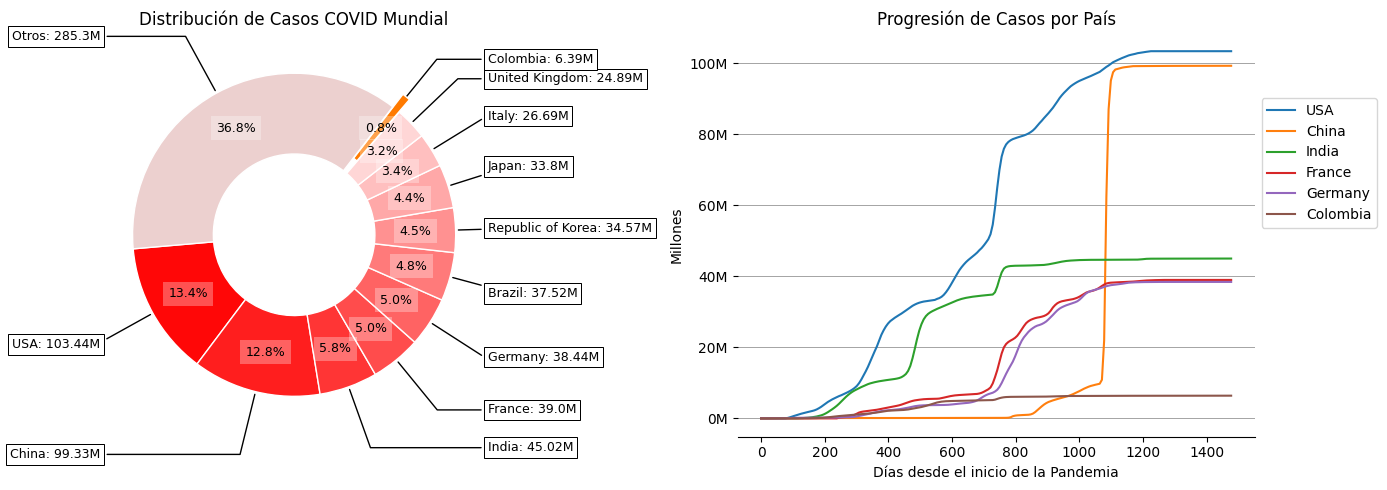

In [ ]:
# Grafico de Dona y lineas
# top_10_paises_con_otros es de tipo Series
casos = top_10_paises_con_otros
paises = top_10_paises_con_otros.index

serie = pd.Series(casos, index=paises)

# Unificar columnas y convertir a millones con 2 decimales y la letra "M"
df_top_en_millones = pd.Series(serie.index + ': ' + (serie / 1000000).round(2).astype(str) + 'M', name='Cumulative_cases')

# Configuración básica de los gráficos
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
destacar = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0)
colores = ['#FF0707','#FF1E1E','#FF3535','#FF4C4C','#FF6363','#FF7A7A','#FF9191','#FFA8A8','#FFBFBF','#FFD6D6','#ff7a00','#ecd0cf']

# Gráfico de Donas para el top 10
wedges_top10, texts_top10, autotexts_top10 = axs[0].pie(casos, explode=destacar, colors=colores, autopct='%1.1f%%',
                                                       textprops={'fontsize': 9, 'bbox': dict(facecolor="white", edgecolor="black", linewidth=0, alpha=0.3)}, pctdistance=0.75,
                                                       startangle=185, wedgeprops=dict(width=0.5, edgecolor='w'))

bbox_paises = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
lines = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_paises, zorder=0, va="center")
for i, p in enumerate(wedges_top10):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    lines["arrowprops"].update({"connectionstyle": connectionstyle})
    axs[0].annotate(df_top_en_millones[i], xy=(x, y), xytext=(1.2*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **lines, fontsize=9)

axs[0].set_title('Distribución de Casos COVID Mundial')

# ---------------------------------
# Gráfico de Líneas para el top 5
for pais in top_5_paises:
    days_since_start = (total_acumulado_top_5.columns - total_acumulado_top_5.columns[0]).days
    axs[1].plot(days_since_start, total_acumulado_top_5.loc[pais], label=pais)

# Formatear el eje Y con numeros entreos y 'M' para millones
def millones(x, _):
  rounded_value = round(x*0.000001)
  return f'{int(rounded_value):,}M'

axs[1].yaxis.set_major_formatter(FuncFormatter(millones))
axs[1].grid(axis='y', linestyle='-', linewidth=0.5, color='gray')
axs[1].set_title('Progresión de Casos por País')
axs[1].set_xlabel('Días desde el inicio de la Pandemia')
axs[1].set_ylabel('Millones')
axs[1].legend(loc='lower left', bbox_to_anchor=(1, 0.5))

# Ajustes finales y visualización
plt.tight_layout()
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)

plt.show()

Conclusión:
- Gráfica de dona: La distribución de casos covid es bastante baja con respecto a los países más importantes con un 0.8% de impácto, con casos reportados de 6.39 Millones.
- Gráfica de líneas: A pesar de experimetnar un aumento significativo en el día 400 desde el inicio de la pandemia, la evolución de casos en Colombia se mantuvo bajo control en comparación con los países líderes

## 2. ¿Cuál ha sido la evolución de los nuevos casos diarios reportados de Covid-19 en el país a lo largo del tiempo?

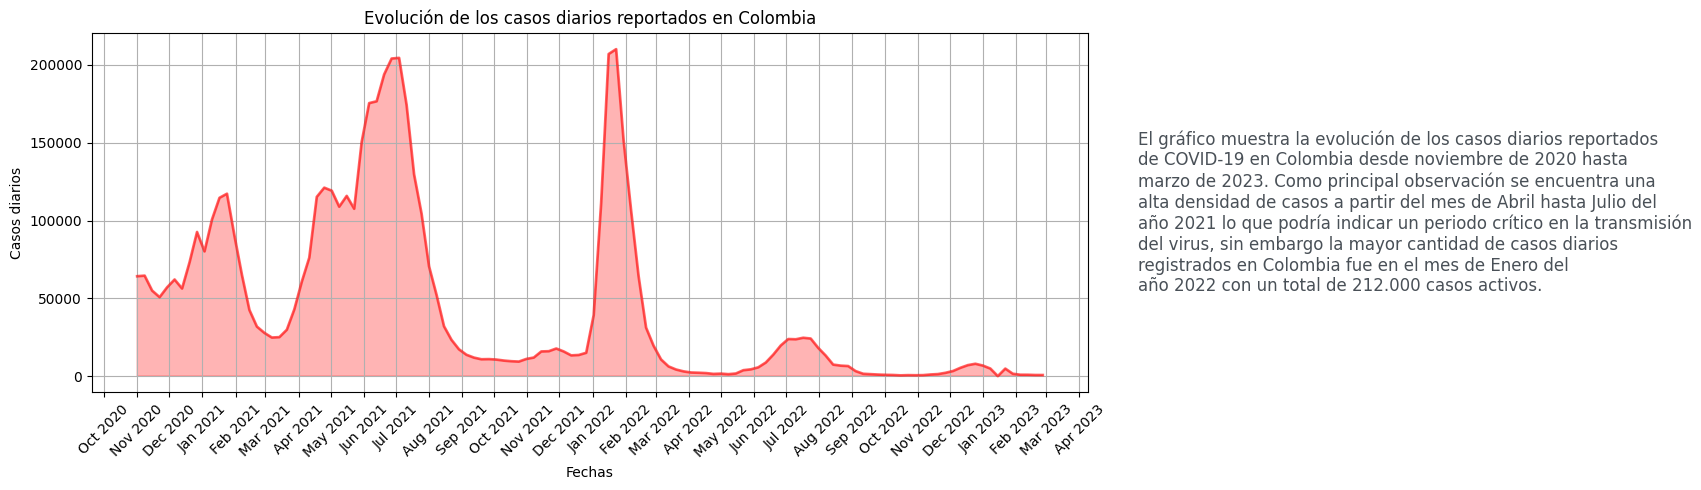

In [ ]:
# Filtrar los datos para el rango de fechas para centralizar los datos
df_filter = df_colombia[(df_colombia['Date_reported'] >= '2020-11-01') & (df_colombia['Date_reported'] <= '2023-03-01')]

# Creación de la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 5))

# Generar un gráfico de líneas con relleno
ax.fill_between(df_filter['Date_reported'], df_filter['New_cases'], color=colores, alpha=0.3)
ax.plot(df_filter['Date_reported'], df_filter['New_cases'], color="#FF0707", alpha=0.6, linewidth=2)

ax.set_title('Evolución de los casos diarios reportados en Colombia')
ax.set_xlabel('Fechas')
ax.set_ylabel('Casos diarios')

# Mejorar el formato de la fecha
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.grid(True)

# Agregar conclusion a la derecha del gráfico
conclusion_text = ("El gráfico muestra la evolución de los casos diarios reportados\n"
                   "de COVID-19 en Colombia desde noviembre de 2020 hasta\n"
                   "marzo de 2023. Como principal observación se encuentra una\n"
                   "alta densidad de casos a partir del mes de Abril hasta Julio del\n"
                   "año 2021 lo que podría indicar un periodo crítico en la transmisión\n"
                   "del virus, sin embargo la mayor cantidad de casos diarios\n"
                   "registrados en Colombia fue en el mes de Enero del\n"
                   "año 2022 con un total de 212.000 casos activos.")

# Para colocar el texto fuera del gráfico, ajustamos las coordenadas y utilizamos transform=fig.transFigure
fig.text(1.05, 0.5, conclusion_text, fontsize=12, color='#495057', va='center', ha='left', transform=ax.transAxes)

plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()


## 3. ¿Cuál es la evolución del índice de letalidad del Covid-19 en el país, comparado con los países con los índices históricos más elevados?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238 entries, 6543 to 48
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      238 non-null    datetime64[ns]
 1   Country_code       238 non-null    object        
 2   Country            238 non-null    object        
 3   New_cases          238 non-null    int64         
 4   Cumulative_cases   238 non-null    int64         
 5   New_deaths         238 non-null    int64         
 6   Cumulative_deaths  238 non-null    int64         
 7   lethality_rate     238 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 16.7+ KB
None
Id
Date_reported        0
Country_code         0
Country              0
New_cases            0
Cumulative_cases     0
New_deaths           0
Cumulative_deaths    0
lethality_rate       0
dtype: int64


<ipython-input-56-f819867bf70a>:38: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.annotate(f'{max_point_colombia["lethality_rate"]/100:.2%}',


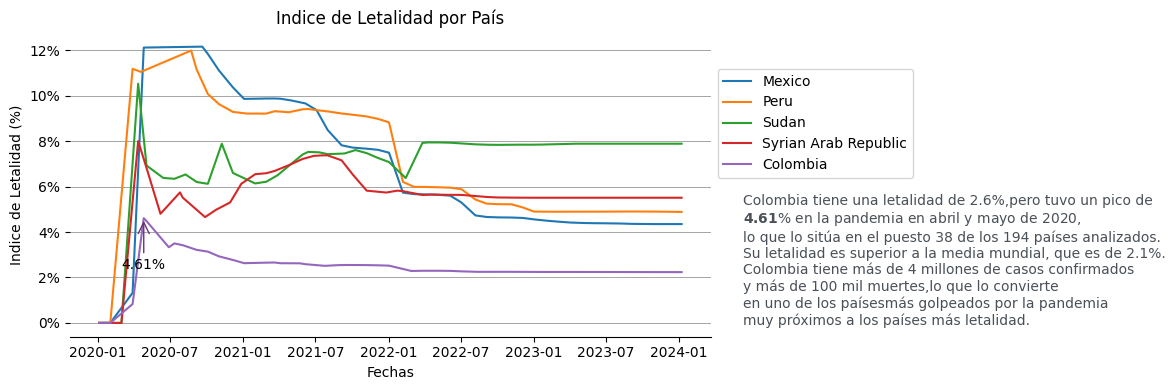

In [ ]:
#Lethality Rate by Country
def get_max_row(group, column):
    return group.loc[group[column].idxmax()]

result = df_covid_limpio.groupby(['Country', df_covid_limpio['Date_reported'].dt.to_period("M")]).apply(lambda group: get_max_row(group, 'lethality_rate'))
result.reset_index(drop=True, inplace=True)
top_4_paises = result.groupby('Country')['lethality_rate'].mean().nlargest(4).index
result = result[result['Country'].isin(top_4_paises)]
result_pais = df_covid_limpio[df_covid_limpio['Country'] == 'Colombia'].groupby(df_covid_limpio['Date_reported'].dt.to_period("M")).apply(lambda group: get_max_row(group, 'lethality_rate'))
result_pais.reset_index(drop=True, inplace=True)
result_final = pd.concat([result, result_pais])
print(result_final.info())
print(result_final.isnull().sum())

# Crea el gráfico de líneas
fig, ax = plt.subplots(figsize=(12, 4))
for pais in result_final['Country'].unique():
    country_data = result_final[result_final['Country'] == pais]
    ax.plot(country_data['Date_reported'], country_data['lethality_rate'], label=pais)

# Formatear el eje Y con numeros entreos y 'M' para millones
def porcentaje(x, _):
  rounded_value = round(x*1)
  return f'{int(rounded_value):,}%'

# Filtrar los datos solo para Colombia
colombia_data = result_final[result_final['Country'] == 'Colombia']

# Encontrar el punto más alto en la gráfica para Colombia
max_point_colombia = colombia_data.loc[colombia_data['lethality_rate'].idxmax()]

# Añadir la flecha al pico más alto de Colombia
bbox_pico = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
#lines = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_paises, zorder=0, va="center")

arrow_properties = dict(facecolor='red', edgecolor='red', arrowstyle='->', mutation_scale=20, color='#683475')

ax.annotate(f'{max_point_colombia["lethality_rate"]/100:.2%}',
            xy=(max_point_colombia['Date_reported'], max_point_colombia['lethality_rate']),
            xytext=(max_point_colombia['Date_reported'], max_point_colombia['lethality_rate'] - 2.25),
            arrowprops=arrow_properties,
            ha='center')

text_below_legend = ("Colombia tiene una letalidad de 2.6%,"
  "pero tuvo un pico de\n$\\bf{4.61}$% en la pandemia en abril y mayo de 2020,\n"
  "lo que lo sitúa en el puesto 38 de los 194 países analizados.\n"
  "Su letalidad es superior a la media mundial, que es de 2.1%.\n"
  "Colombia tiene más de 4 millones de casos confirmados\n"
  "y más de 100 mil muertes,lo que lo convierte\nen uno de los países"
  "más golpeados por la pandemia \nmuy próximos a los países con más letalidad.")
ax.text(1.05, 0.25, text_below_legend, transform=ax.transAxes, fontsize=10,  color='#495057', va='center')

ax.yaxis.set_major_formatter(FuncFormatter(porcentaje))
ax.grid(axis='y', linestyle='-', linewidth=0.5, color='gray')
ax.set_title('Indice de Letalidad por País')
ax.set_xlabel('Fechas')
ax.set_ylabel('Indice de Letalidad (%)')
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

# Ajustes finales y visualización
plt.tight_layout()
# Ocultar las líneas de los ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## 4. Desde una perspectiva demográfica, ¿cuáles son las características que tienen un mayor impacto en el índice de letalidad de un país?

<ipython-input-25-c544a7cfb780>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('Reds', num_colors)


#fff5f0
#fdcab5
#fc8a6a
#f14432
#bc141a
#67000d


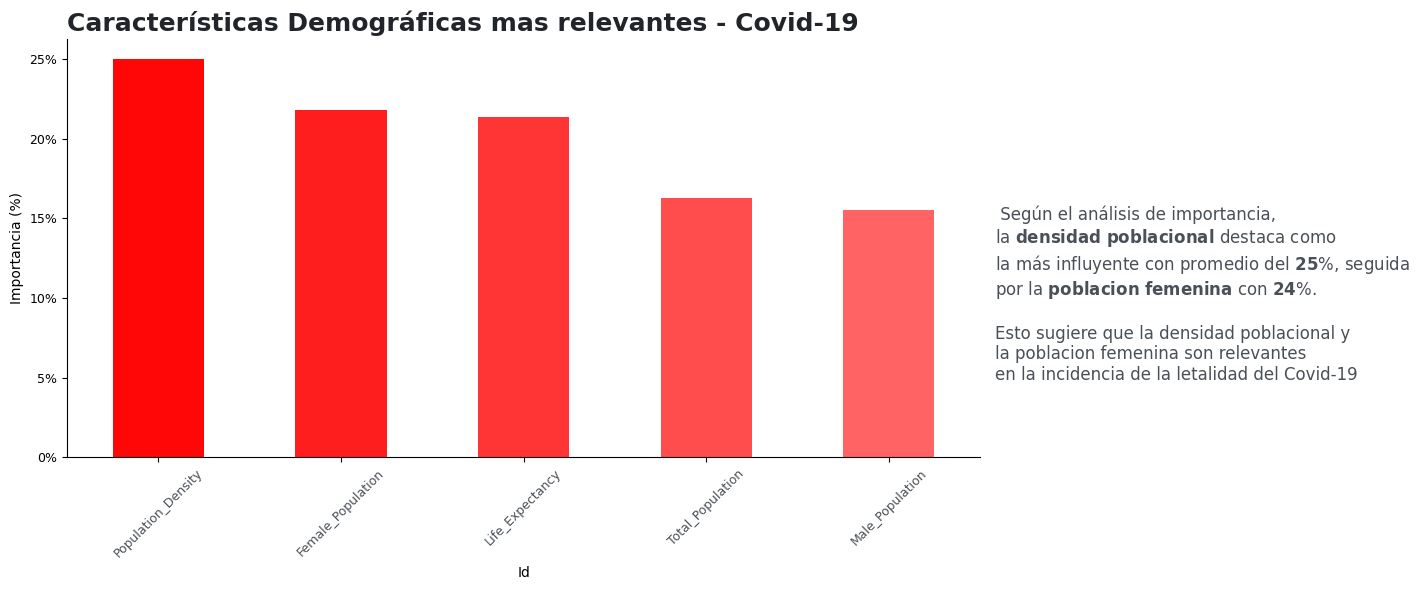

In [ ]:
df_filtrado = df_covid_limpio[df_covid_limpio['Date_reported'] <= '2020-12-31']
df_agrupado = df_filtrado.groupby(['Country_code', 'Country'], as_index=False)['lethality_rate'].mean()
df_resultado = df_agrupado[['Country_code', 'Country', 'lethality_rate']]
df_final = pd.merge(df_resultado, df_population_limpio, on='Country_code', how='inner')
columnas_seleccionadas = ['Country_code', 'Country', 'lethality_rate', 'Total_Population', 'Male_Population', 'Female_Population', 'Population_Density', 'Life_Expectancy']
df_final = df_final[columnas_seleccionadas]

X_numeric = df_final.drop(['lethality_rate'], axis=1).select_dtypes(include=['float64', 'int64'])
y_numeric = df_final['lethality_rate']
model = RandomForestRegressor()
model.fit(X_numeric, y_numeric)
feature_importances = pd.Series(model.feature_importances_, index=X_numeric.columns)

fig, ax = plt.subplots(figsize=(10, 6))

# Número de colores en la paleta
num_colors = 6
# Obtener la paleta de colores "Reds" con el número especificado de colores
color_palette = plt.cm.get_cmap('Reds', num_colors)

# Crear una lista de colores
red_colors = color_palette(range(num_colors))

# Imprimir la lista de colores en formato hexadecimal
for color in red_colors:
    print(matplotlib.colors.to_hex(color))

feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.plot(kind = 'bar', color = colores, ax = ax)
ax.set_title('Características Demográficas mas relevantes - Covid-19', fontsize=18, color='#212529', loc='left', fontweight='bold')
ax.set_ylabel('Importancia (%)')

# Formatear el eje Y con numeros enteros y 'M' para millones
def percentage_formatter(x, _):
  rounded_value = round(x*100, 0)
  return f'{int(rounded_value):,}%'

ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

ax.tick_params(axis = 'y', labelsize = 9)
ax.tick_params(axis = 'x', rotation = 45, labelsize = 9)
ax.xaxis.set_tick_params(labelsize = 9, labelcolor = '#495057')
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Agregar conclusion a la derecha del gráfico
conclusion_text = (" Según el análisis de importancia,\n"
  "la $\\bf{densidad}$ $\\bf{poblacional}$ destaca como\n"
  "la más influyente con promedio del $\\bf{25}$%, seguida\n"
  "por la $\\bf{poblacion }$ $\\bf{femenina}$ con $\\bf{24}$%.\n\n"
  "Esto sugiere que la densidad poblacional y\n"
  "la poblacion femenina son relevantes \n"
  "en la incidencia de la letalidad del Covid-19")
fig.text(1, 0.5, conclusion_text, fontsize=12, color='#495057', va='center', ha='left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()